In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
FOLDERPATH = "C:\\Users\\Benson\\Desktop\\lyftlong\\"
agents_df = pd.read_csv(FOLDERPATH + 'rand_agents_table0.csv')
frame_df = pd.read_csv(FOLDERPATH + 'rand_frames_table1.csv')
scene_df = pd.read_csv(FOLDERPATH + 'rand_scenes_table1.csv')

In [3]:
agents_df = agents_df.merge(frame_df[['frame_index', 'scene_index']], on='frame_index')
agents_df

,centroid_x,centroid_y,extent_x,extent_y,extent_z,velocity_x,velocity_y,yaw,track_id,PERCEPTION_LABEL_NOT_SET,...,PERCEPTION_LABEL_OTHER_VEHICLE,PERCEPTION_LABEL_BICYCLE,PERCEPTION_LABEL_MOTORCYCLE,PERCEPTION_LABEL_CYCLIST,PERCEPTION_LABEL_MOTORCYCLIST,PERCEPTION_LABEL_PEDESTRIAN,PERCEPTION_LABEL_ANIMAL,AVRESEARCH_LABEL_DONTCARE,frame_index,scene_index
0,698.486755,-2145.407959,4.673678,1.868149,1.693981,0.000000,0.000000,-2.167036,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944117,7827
1,675.231079,-2192.097168,5.000620,1.968199,1.885538,0.000000,0.000000,0.986228,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944117,7827
2,643.392517,-2245.469971,3.477908,1.227453,0.840264,0.000000,0.000000,-1.492509,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944117,7827
3,730.271973,-2107.815430,3.389654,1.930534,1.651110,0.000000,0.000000,0.990256,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944117,7827
4,722.959167,-2193.093750,4.205712,0.837930,0.948766,0.000000,0.000000,1.048491,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944117,7827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950238,-491.385742,864.927673,2.848036,0.763638,0.622487,0.000000,0.000000,2.318647,1139,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3831700,15427
1950239,-505.117371,878.250977,2.903636,1.665225,1.623982,-2.190619,-4.000348,1.251474,1140,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3831700,15427
1950240,-481.887299,829.500305,0.646427,0.691510,1.779913,0.000000,0.000000,-0.805097,1141,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3831700,15427
1950241,-496.772369,897.305176,4.354274,1.802668,1.611001,0.000000,0.000000,-3.006293,1142,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3831700,15427


In [4]:
# 0=unknown, 1=car, 2=cyclist, 3=pedestrian

In [5]:

agents_df['speed'] = np.sqrt(agents_df['velocity_x']**2 + agents_df['velocity_y']**2) 
# put speed column before groupby mean
agents_df_grouped = agents_df.groupby(['scene_index','track_id'], as_index = False).mean()
drop_rows = ['PERCEPTION_LABEL_NOT_SET', 'PERCEPTION_LABEL_DONTCARE', 'PERCEPTION_LABEL_MOTORCYCLIST',
             'PERCEPTION_LABEL_ANIMAL']
agents_df_grouped = agents_df_grouped.drop(drop_rows, axis=1)
agents_df_grouped = agents_df_grouped.drop(agents_df_grouped.columns[12:20], axis=1)
# agents_df_grouped['speed'] = np.sqrt(agents_df_grouped['velocity_x']**2 + agents_df_grouped['velocity_y']**2)
agents_df_grouped

,scene_index,track_id,centroid_x,centroid_y,extent_x,extent_y,extent_z,velocity_x,velocity_y,yaw,PERCEPTION_LABEL_UNKNOWN,PERCEPTION_LABEL_CAR,PERCEPTION_LABEL_CYCLIST,PERCEPTION_LABEL_PEDESTRIAN,AVRESEARCH_LABEL_DONTCARE,frame_index,speed
0,112,1,-458.669061,811.974615,4.011284,1.852369,1.464127,7.684069,-8.310170,-0.830219,0.0,1.0,0.0,0.0,0.0,27937.5,11.318509
1,112,2,-539.189974,915.266052,4.161717,1.656362,1.205087,0.087901,0.142778,-0.825563,0.0,1.0,0.0,0.0,0.0,27831.5,0.201644
2,112,3,-457.571522,821.202000,3.498475,1.977805,1.295687,9.132508,-9.910145,-0.807267,0.0,1.0,0.0,0.0,0.0,27889.0,13.476794
3,112,4,-530.073531,872.338991,3.952882,1.559683,1.175224,-0.046915,0.013216,0.519006,0.0,1.0,0.0,0.0,0.0,27853.0,0.153246
4,112,5,-522.541345,896.300813,4.251729,1.638036,1.282184,1.021973,-1.031020,-0.772174,0.0,1.0,0.0,0.0,0.0,27825.0,1.456870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125459,15982,988,-1012.042969,1433.786743,3.350825,1.283732,0.632749,0.000000,0.000000,-0.778701,0.0,1.0,0.0,0.0,0.0,3969525.0,0.000000
125460,15982,989,-1014.040405,1443.542725,0.764975,1.259111,0.950618,0.000000,0.000000,2.381792,0.0,1.0,0.0,0.0,0.0,3969525.0,0.000000
125461,15982,990,-1030.072998,1459.969238,1.584556,1.274177,0.566978,0.000000,0.000000,2.405967,0.0,1.0,0.0,0.0,0.0,3969525.0,0.000000
125462,15982,991,-949.636292,1391.866455,0.874429,0.437873,0.563465,0.000000,0.000000,-0.000034,1.0,0.0,0.0,0.0,0.0,3969525.0,0.000000


In [6]:
unknown = np.array(agents_df_grouped['PERCEPTION_LABEL_UNKNOWN'])
car = np.array(agents_df_grouped['PERCEPTION_LABEL_CAR'])
cyclist = np.array(agents_df_grouped['PERCEPTION_LABEL_CYCLIST'])
ped = np.array(agents_df_grouped['PERCEPTION_LABEL_PEDESTRIAN'])
category = np.array([unknown, car, cyclist, ped])
category_arr = category.T
categories = np.argmax(category_arr, axis=1)
agents_df_grouped['PERCEPTION_CATEGORY'] = categories
agents_df_grouped

,scene_index,track_id,centroid_x,centroid_y,extent_x,extent_y,extent_z,velocity_x,velocity_y,yaw,PERCEPTION_LABEL_UNKNOWN,PERCEPTION_LABEL_CAR,PERCEPTION_LABEL_CYCLIST,PERCEPTION_LABEL_PEDESTRIAN,AVRESEARCH_LABEL_DONTCARE,frame_index,speed,PERCEPTION_CATEGORY
0,112,1,-458.669061,811.974615,4.011284,1.852369,1.464127,7.684069,-8.310170,-0.830219,0.0,1.0,0.0,0.0,0.0,27937.5,11.318509,1
1,112,2,-539.189974,915.266052,4.161717,1.656362,1.205087,0.087901,0.142778,-0.825563,0.0,1.0,0.0,0.0,0.0,27831.5,0.201644,1
2,112,3,-457.571522,821.202000,3.498475,1.977805,1.295687,9.132508,-9.910145,-0.807267,0.0,1.0,0.0,0.0,0.0,27889.0,13.476794,1
3,112,4,-530.073531,872.338991,3.952882,1.559683,1.175224,-0.046915,0.013216,0.519006,0.0,1.0,0.0,0.0,0.0,27853.0,0.153246,1
4,112,5,-522.541345,896.300813,4.251729,1.638036,1.282184,1.021973,-1.031020,-0.772174,0.0,1.0,0.0,0.0,0.0,27825.0,1.456870,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125459,15982,988,-1012.042969,1433.786743,3.350825,1.283732,0.632749,0.000000,0.000000,-0.778701,0.0,1.0,0.0,0.0,0.0,3969525.0,0.000000,1
125460,15982,989,-1014.040405,1443.542725,0.764975,1.259111,0.950618,0.000000,0.000000,2.381792,0.0,1.0,0.0,0.0,0.0,3969525.0,0.000000,1
125461,15982,990,-1030.072998,1459.969238,1.584556,1.274177,0.566978,0.000000,0.000000,2.405967,0.0,1.0,0.0,0.0,0.0,3969525.0,0.000000,1
125462,15982,991,-949.636292,1391.866455,0.874429,0.437873,0.563465,0.000000,0.000000,-0.000034,1.0,0.0,0.0,0.0,0.0,3969525.0,0.000000,0


In [7]:
def find_misrecorded_oversized_track_ids(agents_df_grouped):
    """
        filters the objects/track_ids with unusually big lengths/widths from agents_df_grouped.
        In the US, all vehicles cannot have a sidelength that's more than 19.8 meters;
        Some cars in the agent_table have mean extents that are higher than that, 
        so it was likely a data mistake.
        
        Args:
            agents_df_grouped (pd.DataFrame): the agents table AFTER you applied groupby mean, not the original csv agents_df
        Returns:
            (pd.DataFrame): table with misrecorded, oversized track ids
    """    
    # This means getting all rows with extent_x or extent_y that are longer than 19.8
    # "|" means or. We have to check both extents x and y because we don't know which one is length or width.
    # overbig_track_ids is a table with all of those big vehicles
    MAX_LENGTH_VEHICLES = 19.8 # federally mandated maximum length of vehicles in meters
    
    misrecorded_oversized_track_ids_rows = agents_df_grouped[(agents_df_grouped.extent_x > MAX_LENGTH_VEHICLES) |
                                                        (agents_df_grouped.extent_y > MAX_LENGTH_VEHICLES)]
    return misrecorded_oversized_track_ids_rows

def remove_misrecorded_oversized_track_ids_from_given_table(input_agent_table,
                                                            misrecorded_oversized_track_ids_rows):
    # Really confusing operation: To be simple, this just removes all instances of the
    # misrecorded oversized track_ids from the given agent table
    misrecorded_oversized_track_ids_rows = misrecorded_oversized_track_ids_rows[["scene_index", "track_id"]]
    merged = pd.merge(input_agent_table,misrecorded_oversized_track_ids_rows, how='outer', 
                      on=["scene_index", "track_id"], indicator=True)
    left_anti_merge = merged[merged['_merge'] == 'left_only']#.drop(columns=["_merged"])
    left_anti_merge = left_anti_merge.drop(columns=["_merge"])
    input_agent_table_with_oversized_track_ids_removed = left_anti_merge   
    return input_agent_table_with_oversized_track_ids_removed


In [8]:
misrecorded_oversized_track_ids_rows = find_misrecorded_oversized_track_ids(agents_df_grouped)
# remove misrecorded_oversized_track_ids from the original agents_df
agents_df = remove_misrecorded_oversized_track_ids_from_given_table(agents_df,
                                                                    misrecorded_oversized_track_ids_rows)
# remove misrecorded_oversized_track_ids from the agents_df_grouped
agents_df_grouped = remove_misrecorded_oversized_track_ids_from_given_table(agents_df_grouped,
                                                                    misrecorded_oversized_track_ids_rows)

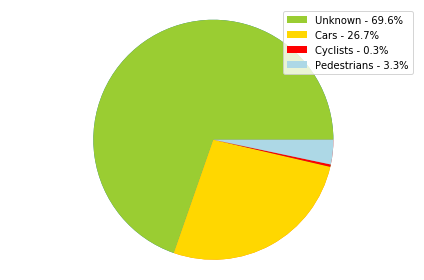

In [9]:
categs = agents_df_grouped["PERCEPTION_CATEGORY"].values
sizes = [list(categs).count(i) for i in set(categs)]
plt.pie(sizes)

import matplotlib.pyplot as plt

# Data to plot
labels = 'Unknown - 69.6%', 'Cars - 26.7%', 'Cyclists - 0.3%', 'Pedestrians - 3.3%'
#colors = ['gold', 'yellowgreen', 'darkblue', 'lightskyblue']

# Plot

import matplotlib.pyplot as plt
explode=(0.0, 0.0, 0.0, 0.0)

colors = ['yellowgreen', 'gold', 'red', 'lightblue']
patches, texts = plt.pie(sizes, explode=explode, colors=colors, shadow=False, startangle=0)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [10]:
(np.array(sizes) / sum(sizes)) * 100 

array([69.66449394, 26.70692206,  0.31831087,  3.31027312])

### RANDOM FORESTING

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrices = []

rf_columns = ['scene_index', 'track_id', 'extent_x', 'extent_y', 'extent_z', 'speed', 'PERCEPTION_CATEGORY']
agents_df_small = agents_df_grouped[rf_columns]
agents_df_small

df_known = agents_df_small[agents_df_small['PERCEPTION_CATEGORY'] != 0]
df_train = df_known.iloc[:, 2:]
# number = len(df_train[df_train['PERCEPTION_CATEGORY'] == 2]) # cyclists, the smallest subset
# df_car = df_train[df_train['PERCEPTION_CATEGORY'] == 1]
# df_cyc = df_train[df_train['PERCEPTION_CATEGORY'] == 2]
# df_ped = df_train[df_train['PERCEPTION_CATEGORY'] == 3]

overall_train_scores = []
overall_test_scores = []

rf_models = None

for i in range(50):
    print(i, "/", 50)
    # df_car_sample = df_car.sample(n=number)
    # df_ped_sample = df_ped.sample(n=number)
    # train_data = pd.concat([df_car_sample, df_ped_sample, df_cyc]).reset_index(drop=True)
    train_data = df_train
    
    train_data = train_data.sample(frac=1).reset_index(drop=True) # shuffles the rows
    
    X = train_data.iloc[:, :4]
    y = train_data['PERCEPTION_CATEGORY']

    train_scores = []
    test_scores = []
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2)

        rf = RandomForestClassifier(class_weight="balanced")
        rf.fit(X_train, y_train)
        
        score_train = rf.score(X_train, y_train)
        score_test = rf.score(X_test, y_test)
        train_scores.append(score_train)
        test_scores.append(score_test)
        
        if rf_models == None:
            model_info = dict()
            model_info["Model"] = rf
            model_info["X_train"] = X_train
            model_info["X_test"] = X_test
            model_info["y_train"] = y_train
            model_info["y_test"] = y_test
            rf_models = (model_info)
        
    overall_train_scores.append(np.mean(train_scores))
    overall_test_scores.append(np.mean(test_scores))

print('Training score: %.5f'
      % np.mean(overall_train_scores))
print('Test score: %.5f'
      % np.mean(overall_test_scores))

### CONFUSION MATRIX

In [39]:
rf  = rf_models["Model"]
X_test = rf_models["X_test"]
y_test = rf_models["y_test"]

Confusion matrix, without normalization
[[6620    7   51]
 [  32   34   14]
 [  32    4  792]]
Normalized confusion matrix
[[0.99 0.   0.01]
 [0.4  0.42 0.17]
 [0.04 0.   0.96]]


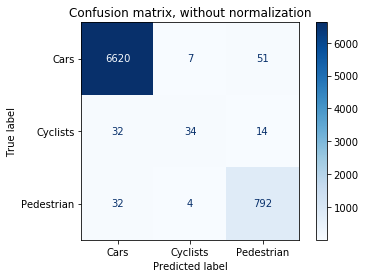

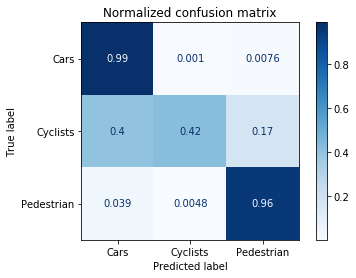

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
class_names = ["Cars", "Cyclists", "Pedestrian"]

# Split the data into a training set and a test set

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### FEATURE IMPORTANCE

Feature: extent_x (length), Score: 0.4705
Feature: extent_y (width), Score: 0.3485
Feature: extent_z (height), Score: 0.1153
Feature: speed, Score: 0.0657


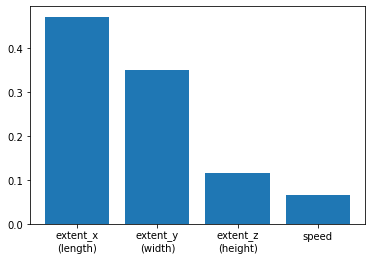

In [41]:
import matplotlib.pyplot as plt
rf_used_features = ['extent_x\n(length)', 'extent_y\n(width)', 'extent_z\n(height)', 'speed']
rf_used_features_ = ['extent_x (length)', 'extent_y (width)', 'extent_z (height)', 'speed']

importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    f = rf_used_features_[i]
    print('Feature: {0}, Score: {1}'.format(f,round(v, 4)))
# plot feature importance
plt.bar(rf_used_features, importance)
plt.show()

### Using Random Forest on the unknown category

In [42]:
df_unknown = agents_df_small[agents_df_small['PERCEPTION_CATEGORY'] == 0]
df_unknown_identifers = df_unknown[rf_columns[:2]]
df_unknown_rf_input = df_unknown[rf_columns[2:-1]].to_numpy()

df_unknown_predicted_categories = rf.predict(df_unknown_rf_input)
print(df_unknown_predicted_categories)

[1 1 1 ... 1 1 1]


df_unknown

In [43]:
unknown_prediction_merger = df_unknown_identifers.copy()
unknown_prediction_merger["PERCEPTION_CATEGORY_merger"] = df_unknown_predicted_categories

agents_df_small1 = agents_df_small.copy()
agents_df_small1 = agents_df_small1.merge(unknown_prediction_merger, how="outer",on=['scene_index', 'track_id'])

In [44]:
temp_df1 = agents_df_small1[["PERCEPTION_CATEGORY_merger"]]
temp_df1 = temp_df1.rename(columns={"PERCEPTION_CATEGORY_merger":"PERCEPTION_CATEGORY"})
temp_df2 = agents_df_small1[["PERCEPTION_CATEGORY"]]
temp_df1 = temp_df1.combine_first(temp_df2)

assert np.all(temp_df1["PERCEPTION_CATEGORY"].values != 0)
agents_df_small["PERCEPTION_CATEGORY"] = temp_df1.PERCEPTION_CATEGORY.values.astype(int)
agents_df_small.rename(columns={"PERCEPTION_CATEGORY": "kind"})

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,scene_index,track_id,extent_x,extent_y,extent_z,speed,kind
0,112,1,4.011284,1.852369,1.464127,11.318509,1
1,112,2,4.161717,1.656362,1.205087,0.201644,1
2,112,3,3.498475,1.977805,1.295687,13.476794,1
3,112,4,3.952882,1.559683,1.175224,0.153246,1
4,112,5,4.251729,1.638036,1.282184,1.456870,1
...,...,...,...,...,...,...,...
125459,15982,988,3.350825,1.283732,0.632749,0.000000,1
125460,15982,989,0.764975,1.259111,0.950618,0.000000,1
125461,15982,990,1.584556,1.274177,0.566978,0.000000,1
125462,15982,991,0.874429,0.437873,0.563465,0.000000,1


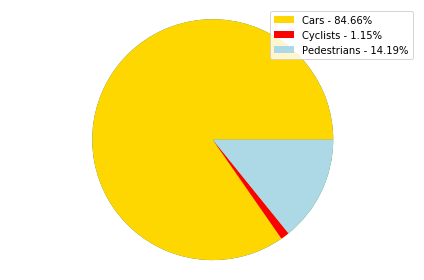

In [45]:
categs = agents_df_small["PERCEPTION_CATEGORY"].values
sizes = [list(categs).count(i) for i in set(categs)]
plt.pie(sizes)

import matplotlib.pyplot as plt

# Data to plot
percentages = list(np.round(((np.array(sizes) / sum(sizes)) * 100),2))
names = ['Cars', 'Cyclists', 'Pedestrians']
labels = [(name+" - {0}%").format(percent) for name, percent in zip(names, percentages)]
#colors = ['gold', 'yellowgreen', 'darkblue', 'lightskyblue']

# Plot

import matplotlib.pyplot as plt
explode=(0.0, 0.0, 0.0)

colors = ['gold', 'red', 'lightblue']
patches, texts = plt.pie(sizes, explode=explode, colors=colors, shadow=False, startangle=0)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [78]:
agents_df_small = agents_df_small.rename(columns={"PERCEPTION_CATEGORY": "kind"})
## All categories have been predicted. There should be NO unknowns (0's) for any classes
assert np.all(agents_df_small["kind"].values != 0)

In [79]:
agents_df

,centroid_x,centroid_y,extent_x,extent_y,extent_z,velocity_x,velocity_y,yaw,track_id,PERCEPTION_LABEL_NOT_SET,...,PERCEPTION_LABEL_BICYCLE,PERCEPTION_LABEL_MOTORCYCLE,PERCEPTION_LABEL_CYCLIST,PERCEPTION_LABEL_MOTORCYCLIST,PERCEPTION_LABEL_PEDESTRIAN,PERCEPTION_LABEL_ANIMAL,AVRESEARCH_LABEL_DONTCARE,frame_index,scene_index,speed
0,698.486755,-2145.407959,4.673678,1.868149,1.693981,0.000000,0.000000,-2.167036,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944117,7827,0.000000
1,697.101990,-2147.395020,2.686584,2.049561,1.677582,0.000000,0.000000,-2.157741,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944118,7827,0.000000
2,696.559937,-2148.291748,2.782353,2.018085,1.685846,-5.663389,-8.918378,-2.160171,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944119,7827,10.564631
3,695.944641,-2149.177734,2.868769,2.045774,1.666778,-6.061299,-9.179122,-2.161492,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944120,7827,10.999801
4,695.390137,-2150.040283,3.034343,1.985472,1.678996,-6.225703,-9.163996,-2.164186,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1944121,7827,11.078727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950238,-505.117371,878.250977,2.903636,1.665225,1.623982,-2.190619,-4.000348,1.251474,1140,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3831700,15427,4.560876
1950239,-481.885895,829.501648,0.646427,0.691510,1.779913,0.000000,0.000000,-0.805076,1141,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3831699,15427,0.000000
1950240,-481.887299,829.500305,0.646427,0.691510,1.779913,0.000000,0.000000,-0.805097,1141,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3831700,15427,0.000000
1950241,-496.772369,897.305176,4.354274,1.802668,1.611001,0.000000,0.000000,-3.006293,1142,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3831700,15427,0.000000


In [80]:
# We must now combine extent_x, extent_y, and kind into the original table agents_df

agents_df_small["mean_area"] = agents_df_small["extent_x"] * agents_df_small["extent_y"]

agents_df = agents_df.merge(agents_df_small[["mean_area", "kind", "track_id", "scene_index"]], on=["track_id", "scene_index"])
agents_df

,centroid_x,centroid_y,extent_x,extent_y,extent_z,velocity_x,velocity_y,yaw,track_id,PERCEPTION_LABEL_NOT_SET,...,PERCEPTION_LABEL_CYCLIST,PERCEPTION_LABEL_MOTORCYCLIST,PERCEPTION_LABEL_PEDESTRIAN,PERCEPTION_LABEL_ANIMAL,AVRESEARCH_LABEL_DONTCARE,frame_index,scene_index,speed,mean_area,kind
0,698.486755,-2145.407959,4.673678,1.868149,1.693981,0.000000,0.000000,-2.167036,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1944117,7827,0.000000,6.967935,1
1,697.101990,-2147.395020,2.686584,2.049561,1.677582,0.000000,0.000000,-2.157741,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1944118,7827,0.000000,6.967935,1
2,696.559937,-2148.291748,2.782353,2.018085,1.685846,-5.663389,-8.918378,-2.160171,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1944119,7827,10.564631,6.967935,1
3,695.944641,-2149.177734,2.868769,2.045774,1.666778,-6.061299,-9.179122,-2.161492,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1944120,7827,10.999801,6.967935,1
4,695.390137,-2150.040283,3.034343,1.985472,1.678996,-6.225703,-9.163996,-2.164186,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1944121,7827,11.078727,6.967935,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946043,-505.117371,878.250977,2.903636,1.665225,1.623982,-2.190619,-4.000348,1.251474,1140,0.0,...,0.0,0.0,0.0,0.0,0.0,3831700,15427,4.560876,4.686579,1
1946044,-481.885895,829.501648,0.646427,0.691510,1.779913,0.000000,0.000000,-0.805076,1141,0.0,...,0.0,0.0,1.0,0.0,0.0,3831699,15427,0.000000,0.447010,3
1946045,-481.887299,829.500305,0.646427,0.691510,1.779913,0.000000,0.000000,-0.805097,1141,0.0,...,0.0,0.0,1.0,0.0,0.0,3831700,15427,0.000000,0.447010,3
1946046,-496.772369,897.305176,4.354274,1.802668,1.611001,0.000000,0.000000,-3.006293,1142,0.0,...,0.0,0.0,0.0,0.0,0.0,3831700,15427,0.000000,7.849310,1


### PART 2: Designating agents as on or off road

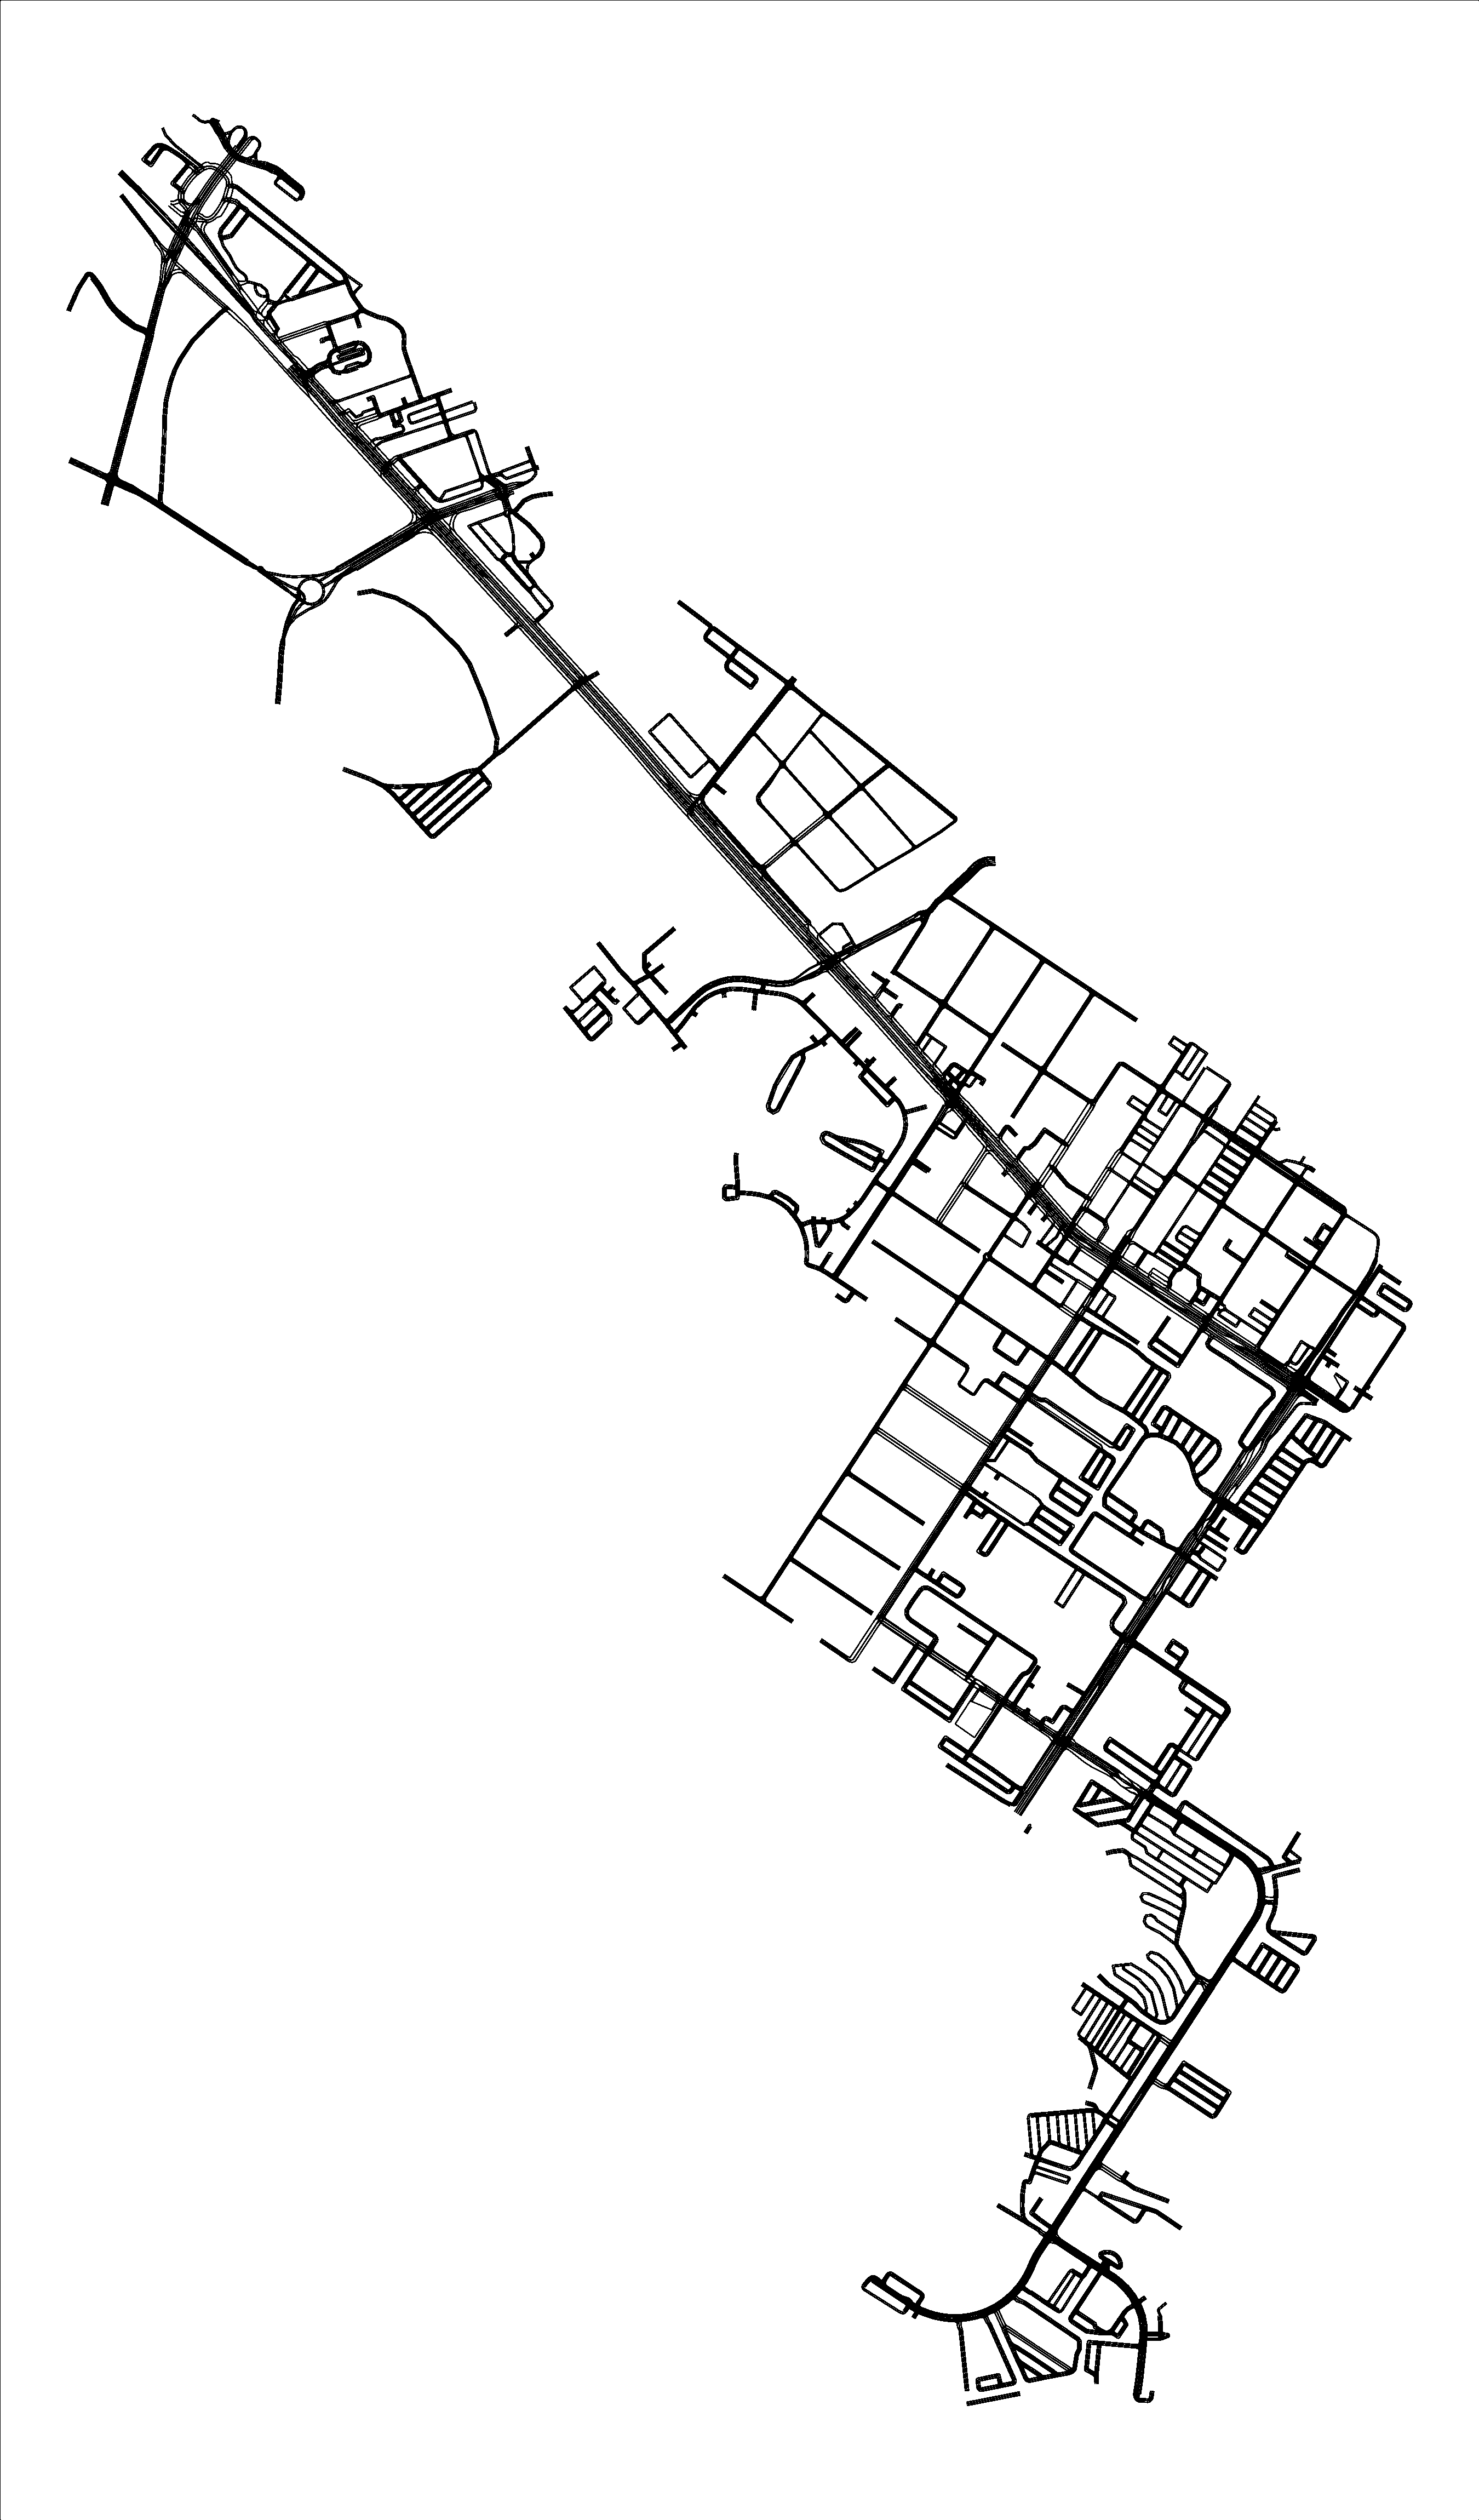

In [82]:
%matplotlib inline
import math as math
import pandas as pd
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from PIL import Image


folderpath = "C:\\Users\\Benson\\Desktop\\"

file = folderpath + "\\lyftlong\\crosswalks_table0.csv"
cw_df = pd.read_csv(file)

def palo_locate(agent_coords, Actual_roadmap):
    # returns a binary list if on or off the road
    
    agent_coords = agent_coords.astype(int) # the x and y coords of the agent table as an array
    
    # The agent table's origin was at (0,0), but for this picture, 
    agent_coords[:,0] = agent_coords[:,0] + 1300 - 15 
    agent_coords[:,1] = agent_coords[:,1] + 2700 + 73
    Actual_roadmap_arr = np.array(Actual_roadmap)
    
    if len(Actual_roadmap_arr.shape) != 2:
        Actual_roadmap_arr = np.dot(Actual_roadmap_arr[...,:3], [0.2989, 0.5870, 0.1140])
    
    on_road = Actual_roadmap_arr[::-1][agent_coords[:,1], agent_coords[:,0]]
    
    return 1-on_road


# This is what the map of our ENTIRE DATASET LOOKS like
mapfile = folderpath + "\\lyftlong\\palo_alto_proper.png"
Actual_roadmap = Image.open(mapfile)
Actual_roadmap

In [83]:
# get coordinates of all the agents in the agent table
agents_df_coords = agents_df[['centroid_x', 'centroid_y']].to_numpy()

on_road = palo_locate(agents_df_coords, Actual_roadmap)

agents_df["on_road"] = on_road
agents_df

,centroid_x,centroid_y,extent_x,extent_y,extent_z,velocity_x,velocity_y,yaw,track_id,PERCEPTION_LABEL_NOT_SET,...,PERCEPTION_LABEL_MOTORCYCLIST,PERCEPTION_LABEL_PEDESTRIAN,PERCEPTION_LABEL_ANIMAL,AVRESEARCH_LABEL_DONTCARE,frame_index,scene_index,speed,mean_area,kind,on_road
0,698.486755,-2145.407959,4.673678,1.868149,1.693981,0.000000,0.000000,-2.167036,1,0.0,...,0.0,0.0,0.0,0.0,1944117,7827,0.000000,6.967935,1,1
1,697.101990,-2147.395020,2.686584,2.049561,1.677582,0.000000,0.000000,-2.157741,1,0.0,...,0.0,0.0,0.0,0.0,1944118,7827,0.000000,6.967935,1,1
2,696.559937,-2148.291748,2.782353,2.018085,1.685846,-5.663389,-8.918378,-2.160171,1,0.0,...,0.0,0.0,0.0,0.0,1944119,7827,10.564631,6.967935,1,1
3,695.944641,-2149.177734,2.868769,2.045774,1.666778,-6.061299,-9.179122,-2.161492,1,0.0,...,0.0,0.0,0.0,0.0,1944120,7827,10.999801,6.967935,1,1
4,695.390137,-2150.040283,3.034343,1.985472,1.678996,-6.225703,-9.163996,-2.164186,1,0.0,...,0.0,0.0,0.0,0.0,1944121,7827,11.078727,6.967935,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946043,-505.117371,878.250977,2.903636,1.665225,1.623982,-2.190619,-4.000348,1.251474,1140,0.0,...,0.0,0.0,0.0,0.0,3831700,15427,4.560876,4.686579,1,1
1946044,-481.885895,829.501648,0.646427,0.691510,1.779913,0.000000,0.000000,-0.805076,1141,0.0,...,0.0,1.0,0.0,0.0,3831699,15427,0.000000,0.447010,3,0
1946045,-481.887299,829.500305,0.646427,0.691510,1.779913,0.000000,0.000000,-0.805097,1141,0.0,...,0.0,1.0,0.0,0.0,3831700,15427,0.000000,0.447010,3,0
1946046,-496.772369,897.305176,4.354274,1.802668,1.611001,0.000000,0.000000,-3.006293,1142,0.0,...,0.0,0.0,0.0,0.0,3831700,15427,0.000000,7.849310,1,1


### SAVE THE AGENT_DF FOREVER, SO BACK UP THE ORIGINAL FILE WITH SOME FORM OF A COPY

In [89]:
for colname in agents_df.columns:
    if "_LABEL_" in colname:
        agents_df = agents_df.drop(columns=[colname])

In [92]:
pd.unique(agents_df["scene_index"])

array([ 7827, 15982, 10378,   154,  9380, 15002,  4455,  8285, 10522,
        2810,  1233,  1094,  3475, 13521,  2989,   385, 13242, 15073,
         721,  5601,  9884,  3818,  1372,  8029,  9520, 14617,  3043,
       13122, 13699, 12155, 15371,  5025,  1495,  8679, 13317,   204,
       14294, 11121, 13106, 14812,  8581,  9953,  5475,  8368,  1162,
       12928,  2595, 15782,   378,  3163, 15761,  2259, 15022, 15410,
         665,  4781, 10834, 12188,  1820, 12334, 15643,  2180,  2281,
        6235, 10847, 11405, 10210, 14560,  8968,  4386,  6303, 11197,
       14339,  2013,  9767, 13168, 11383, 14898,   296,  6343, 12055,
         112, 13893, 11414, 15559, 11667, 15367,  2547,   587, 11458,
       13215, 15416, 14090,  2367, 12803,  7992, 10719, 11029,  8566,
       15427], dtype=int64)

In [98]:
# RE- SORTING THE TABLE

allscene = list(agents_df.scene_index.values)
counts = [allscene.count(idx) for idx in pd.unique(agents_df["scene_index"])]
allcounts = []
for i in range(0, 100):
    scene_count = counts[i]
    scene_counts = [i for _ in range(scene_count)]
    allcounts += scene_counts
    
assert allcounts.count(0) == agents_df.scene_index.values.tolist().count(7827)

agents_df["temp_scene_fixed_frame_sorter"] = allcounts
agents_df = agents_df.sort_values(["temp_scene_fixed_frame_sorter", "frame_index"], ignore_index=True)
agents_df = agents_df.drop(columns=["temp_scene_fixed_frame_sorter"])

### Creating crosswalks polygon list and pickling it

In [101]:
from shapely.geometry import Point, Polygon 

cw_df_orig = pd.read_csv(FOLDERPATH + "\\crosswalks_table0.csv")
cw_df = cw_df_orig.copy()
cw_df["pairs"] = list(np.dstack((cw_df.cw_coord_x.values, cw_df.cw_coord_y.values))[0] )
polygon_vertices_list = cw_df.groupby('cw_id')["pairs"].apply(list)

crosswalk_polygon_list = [Polygon(polygon_vertices) for polygon_vertices in polygon_vertices_list]

import pickle

pickle_filename = "Crosswalk_Polygons_List.pkl"
pickle_file = open(pickle_filename, 'wb')   # Pickle file is newly created where foo1.py is
pickle.dump(polygon_vertices_list, pickle_file)          # dump data to f
pickle_file.close()

In [ ]:
f = open("near_crosswalk_boolean_column.pkl", "rb")
read_datas = pickle.load(f) 
f.close()

In [153]:
agents_df["near_crosswalks"] = read_datas

agents_df.to_csv(FOLDERPATH + 'rand_agents_table0_scene_3kind_onroadDiscrete.csv', index=False)